<a href="https://colab.research.google.com/github/Swathi1309/Data_Analytics/blob/main/Text%20clustering%20and%20labelling/Text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text reviews : Clustering and automatic labelling

## Import libraries

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score as score

from google.colab import drive
drive.mount('/content/drive')

!pip install nltk==3.4
import nltk
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

Mounted at /content/drive
     |████████████████████████████████| 1.4 MB 29.9 MB/s 
  Created wheel for nltk: filename=nltk-3.4-py3-none-any.whl size=1436394 sha256=87b5823254b56a74bbf5aa1440fcf560127d828d044a390e94c44fd6a5f7aa9a
  Stored in directory: /root/.cache/pip/wheels/13/b8/81/2349be11dd144dc7b68ab983b58cd2fae353cdc50bbdeb09d0
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Supporting functions

In [2]:
# Function to preprocess the text data (remove stop words, lemmatize)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(WordNetLemmatizer().lemmatize(token))
    return result

# Function to obtain all bigrams of the given reviews
def ngram_sequence(text_lst, n):
    result = [a for ls in text_lst for a in ngrams(ls.split(), n)]
    return result

In [3]:
# Function for clustering and automatic text labelling
def clustering_and_labelling(data, processed, num_clusters, level_1_name):
  # data contains the tfidf vectors, processed contains all the text data
  tfidf_dataframe = pd.DataFrame(data)

  k_means = KMeans(n_clusters=num_clusters)
  y_pred = k_means.fit_predict(data)

  dist = (euclidean_distances(k_means.cluster_centers_))
  s = score(euclidean_distances(data), y_pred)

  for i in range(num_clusters):
    for j in range(i+1, num_clusters):
      if dist[i, j]<=0.3:
        for k in range(len(y_pred)):
          if y_pred[k]==j:
            y_pred[k]=i

  all_clusters = []
  all_text = []
  for i in range(num_clusters):
    text = []
    data_cluster = pd.DataFrame()
    for j in range(len(y_pred)):
      if int(y_pred[j])==i:
        text.append(processed[j])
        data_cluster = data_cluster.append(tfidf_dataframe.iloc[j, :]);
    if len(text)!=0:
      all_clusters.append(data_cluster)
      all_text.append(text)

  cluster_names = []
  for i in range(len(all_clusters)):
    name_2 = " ".join((Counter(ngram_sequence(all_text[i], 2)).most_common(1))[0][0])
    count_2 = (Counter(ngram_sequence(all_text[i], 2)).most_common(1))[0][1]
    name_1 = " ".join((Counter(ngram_sequence(all_text[i], 1)).most_common(1))[0][0])
    count_1 = (Counter(ngram_sequence(all_text[i], 1)).most_common(1))[0][1]
    if count_1>2*count_2:
      name = name_1
    else:
      name = name_2
    if name==level_1_name:
      name_2 = " ".join((Counter(ngram_sequence(all_text[i], 2)).most_common(2))[1][0])
      count_2 = (Counter(ngram_sequence(all_text[i], 2)).most_common(2))[1][1]
      name_1 = " ".join((Counter(ngram_sequence(all_text[i], 1)).most_common(2))[1][0])
      count_1 = (Counter(ngram_sequence(all_text[i], 1)).most_common(2))[1][1]
      if count_1>2*count_2:
        name = name_1
      else:
        name = name_2
    cluster_names.append(name)

  num_clusters = len(cluster_names)
  cluster_names_all = []
  for i in range(num_clusters):
    for j in range(i+1, num_clusters):
      if cluster_names[i]==cluster_names[j]:
        for k in range(len(y_pred)):
          if y_pred[k]==j:
            y_pred[k]=i
  for i in np.unique(y_pred):
    cluster_names_all.append(cluster_names[i])

  return y_pred, all_clusters, all_text, cluster_names_all, s

In [4]:
# Function to plot the scatter plot of clustering
def plot_scatter(pca_data, pred, names, title):
  fig = plt.figure(figsize=(15, 15))
  ax = fig.add_subplot(projection='3d')
  colors = ['black', 'dimgray', 'lightcoral', 'brown', 'red', 'chocolate', 'orange', 'goldenrod', 'gold', 'olivedrab', 'darkolivegreen', 'yellowgreen', 'seagreen', 'aquamarine', 'lightseagreen', 'teal', 'deepskyblue', 'royalblue', 'midnightblue', 'slateblue', 'darkorchid', 'purple', 'deeppink']
  for i in range(len(pred)):
    ax.scatter(pca_data[i, 0], pca_data[i, 1], pca_data[i, 2], c=colors[pred[i]])
  all_numbers = np.unique(pred)
  if names!=None:
    handles = []
    for i in range(len(names)):
      handles.append(mpatches.Patch(color=colors[all_numbers[i]], label=names[i]))
    ax.legend(handles = handles)
  ax.set_title(title)

In [5]:
# Function to find ideal number of clusters
def find_num_clusters(data, start, end, skip):
  dist = euclidean_distances(data)
  distortions = []
  print ("Start")
  for k in range(start, end+1, skip):
    k_means = KMeans(n_clusters=k)
    y_pred = k_means.fit_predict(data)
    distortions.append(k_means.inertia_)
  plt.plot(range(start, end+1, skip), distortions)
  plt.xlabel("Number of clusters")
  plt.ylabel("Average distortion")

## Importing and processing data

In [6]:
data = pd.read_excel("/content/drive/MyDrive/Salonpas_Sentiment_File.xlsx")
data = data[['Review', 'Aspect', 'Context Aspect']]
data.drop_duplicates(subset = ['Review'], inplace=True)
data.reset_index(inplace=True)
data.drop(columns=['index'], inplace = True)

# Processing the review data
processed = []
for i in range(len(data)):
  doc_sample = data['Review'].values[i]
  words = doc_sample.split(" ")
  processed.append(" ".join(preprocess(doc_sample)))

## Feature extraction

In [13]:
# Using tfidf for feature extraction from text
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", lowercase=True, max_df = 0.6, max_features=100)
tfidf_data = tfidf_vectorizer.fit_transform(processed)
tfidf_data = tfidf_data.toarray()

# Using PCA to find important components (to plot data)
pca = PCA(n_components=3)
pca_data = pca.fit_transform(tfidf_data)

## Visualising the initial clustering of the dataset

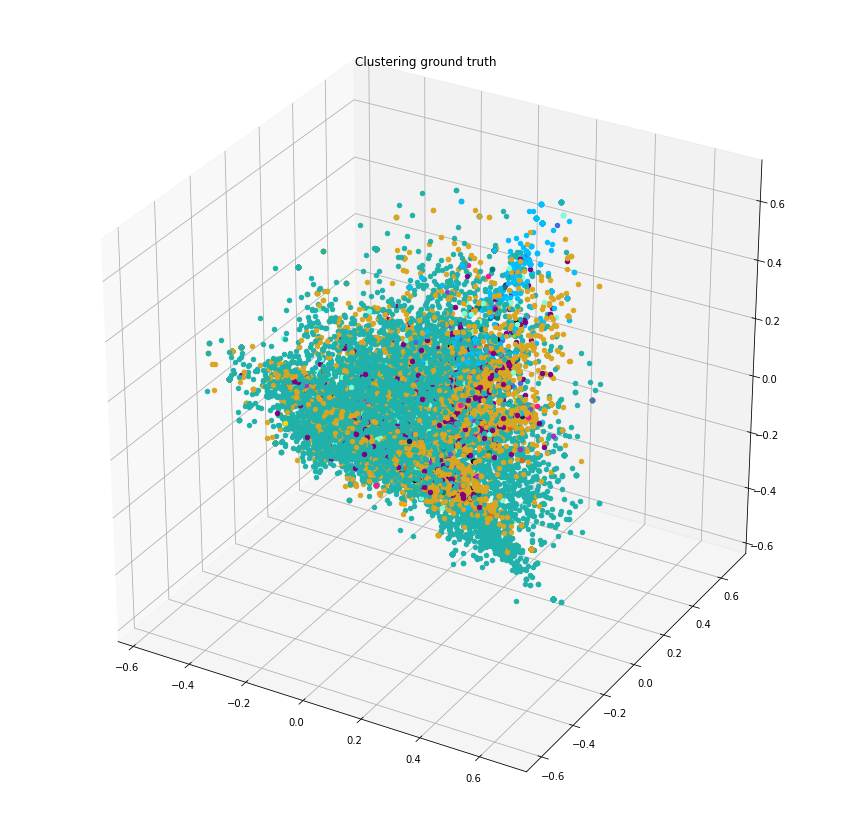

In [8]:
# Adding a new column to encode the level 1 clustering ground truth
le = LabelEncoder()
data['Aspect_Encoded'] = le.fit_transform(data['Aspect'])
labels = list(le.classes_)

# Visualising the clusters
plot_scatter(pca_data, data['Aspect_Encoded'], None, "Clustering ground truth")

## Level 1 clustering using K-Means

Start


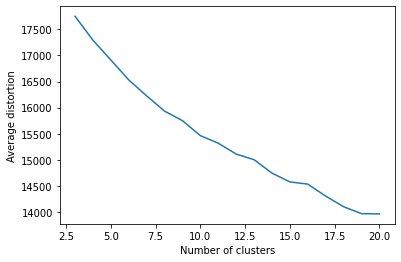

In [9]:
# Finding the ideal number of clusters to use
find_num_clusters(tfidf_data, 3, 20, 1)

Silhouette Score =  0.08565763023687467


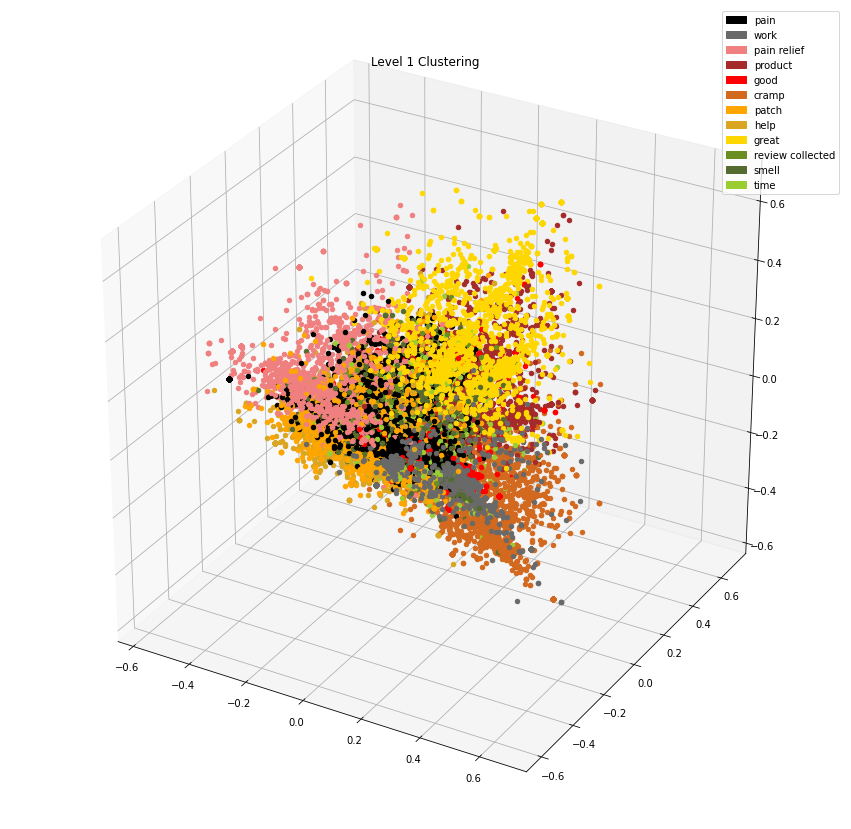

In [14]:
# Hyperparameter to be tuned
num_clusters=12
level_1_pred, level_1_clusters, level_1_text, level_1_names, level_1_score = clustering_and_labelling(tfidf_data, processed, num_clusters, None)

# Visualising the clustering
plot_scatter(pca_data, level_1_pred, level_1_names, "Level 1 Clustering")
print ("Silhouette Score = ", level_1_score)

## Level 2 clustering - for each cluster formed in level 1 clustering

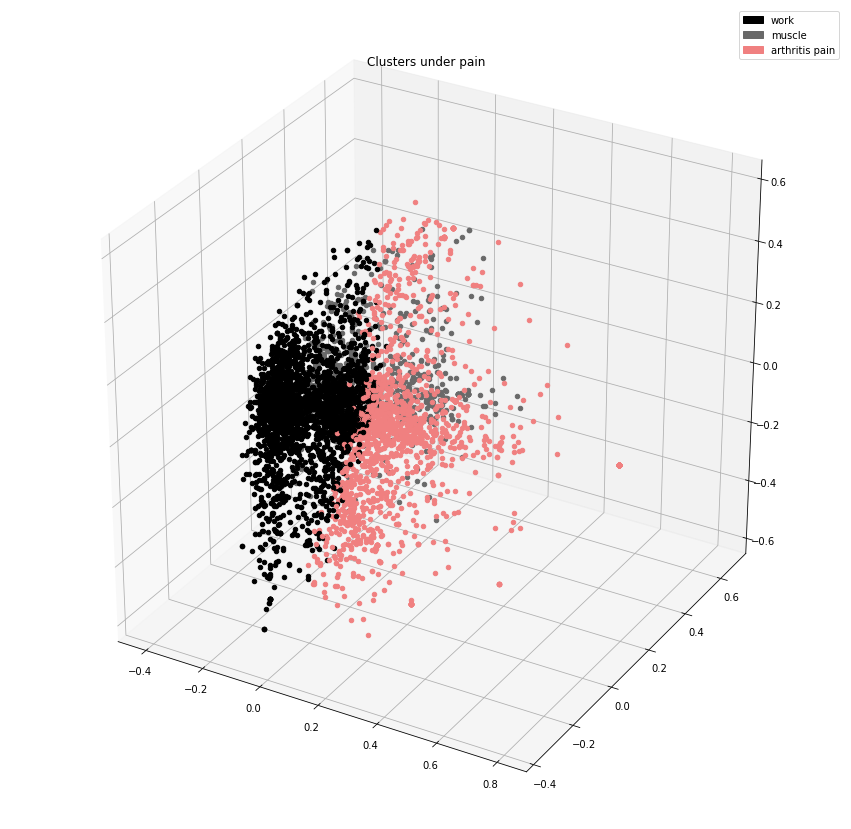

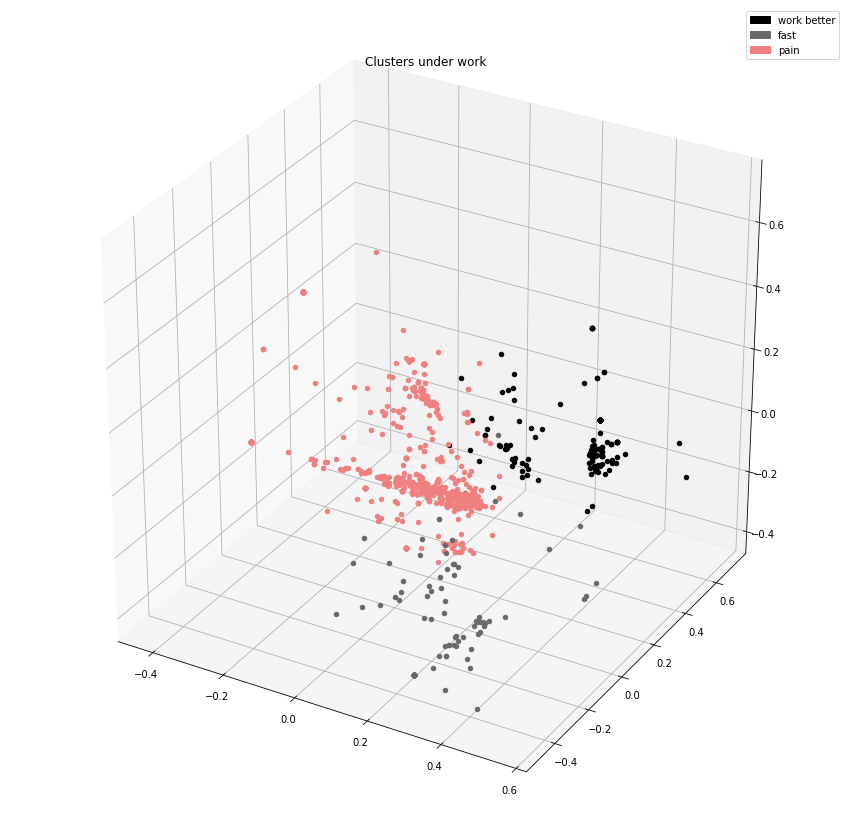

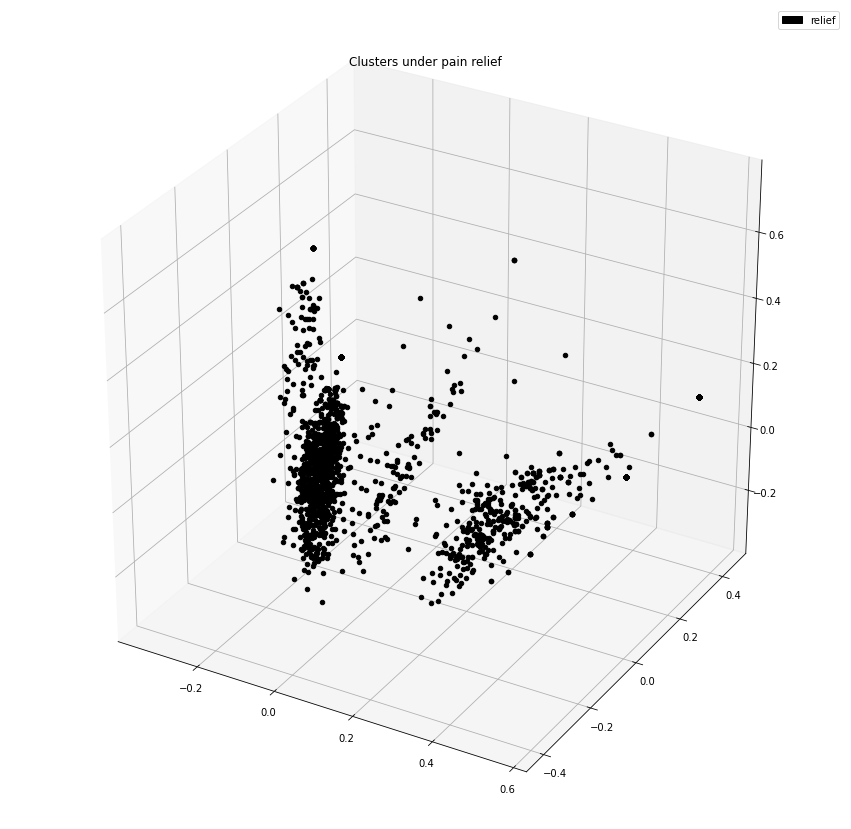

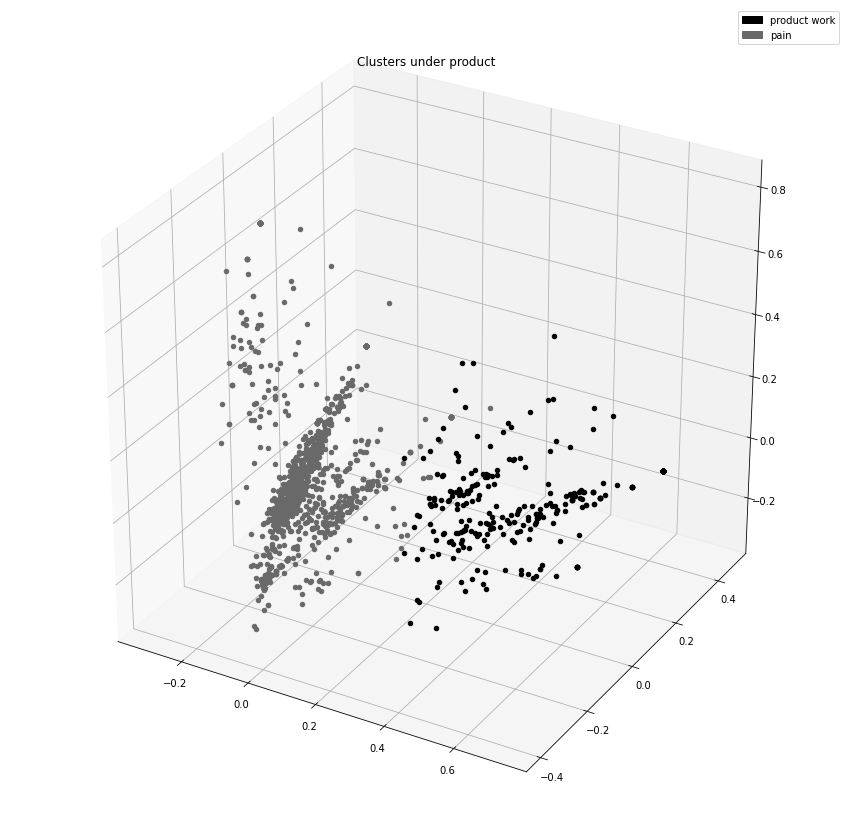

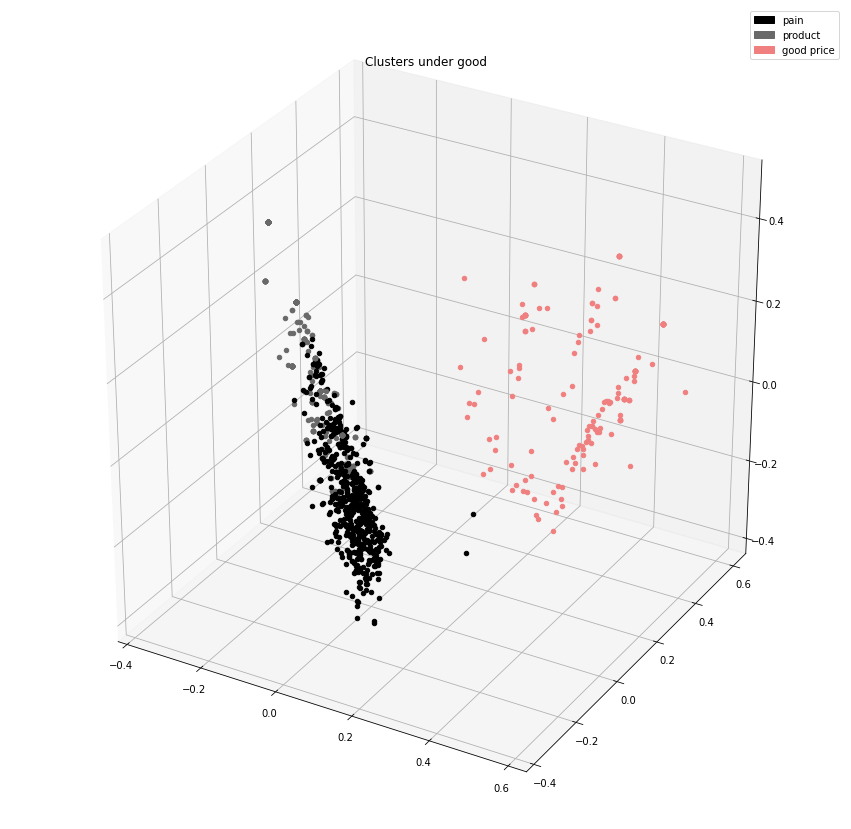

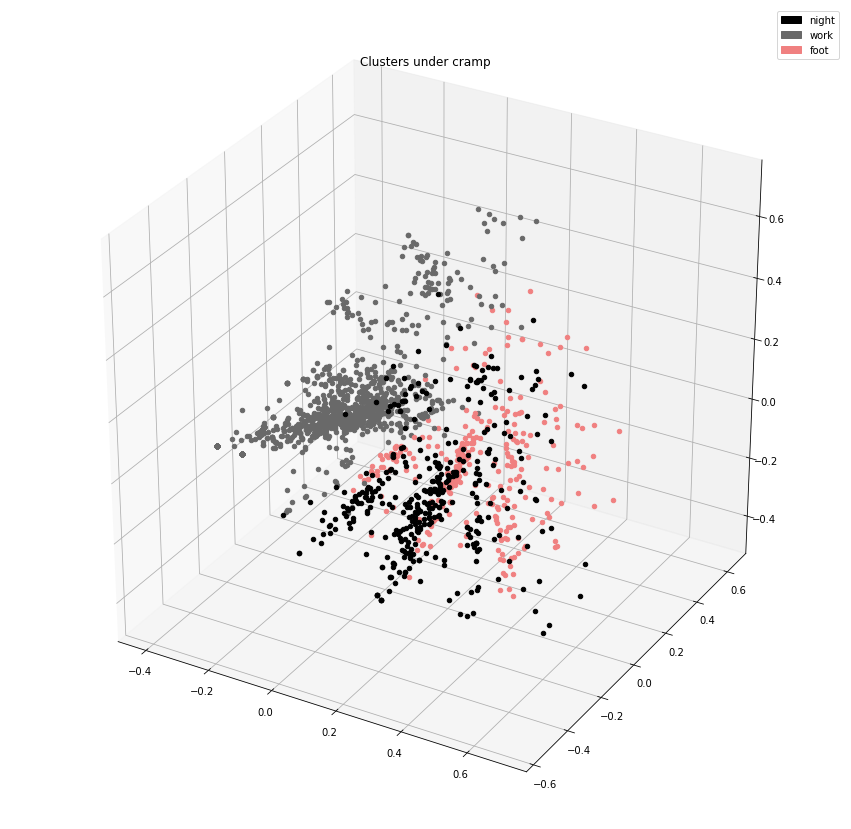

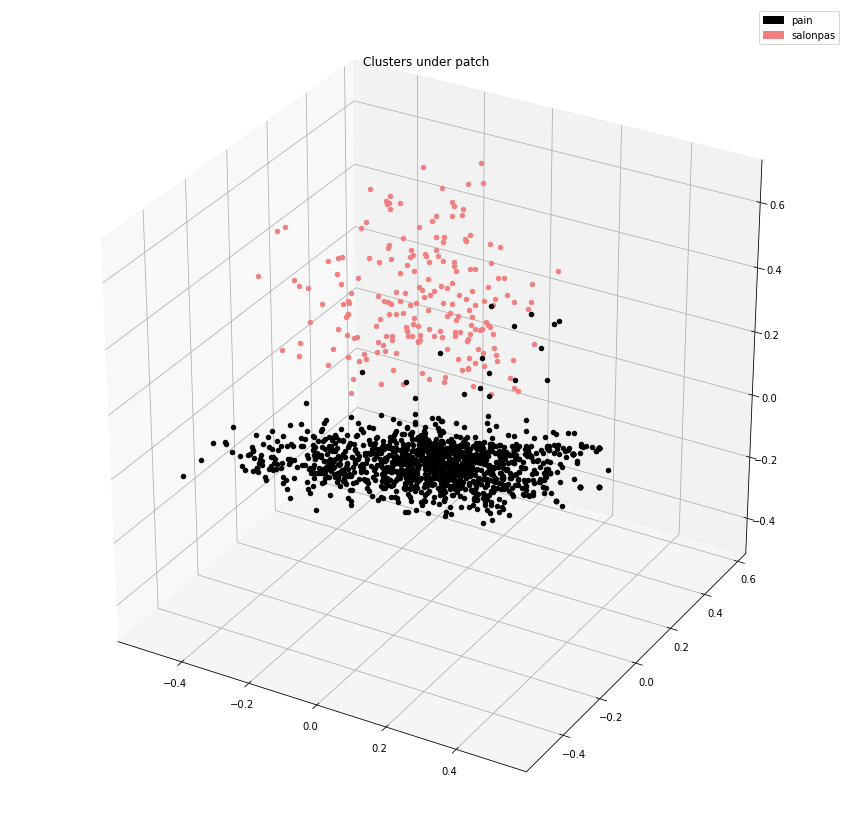

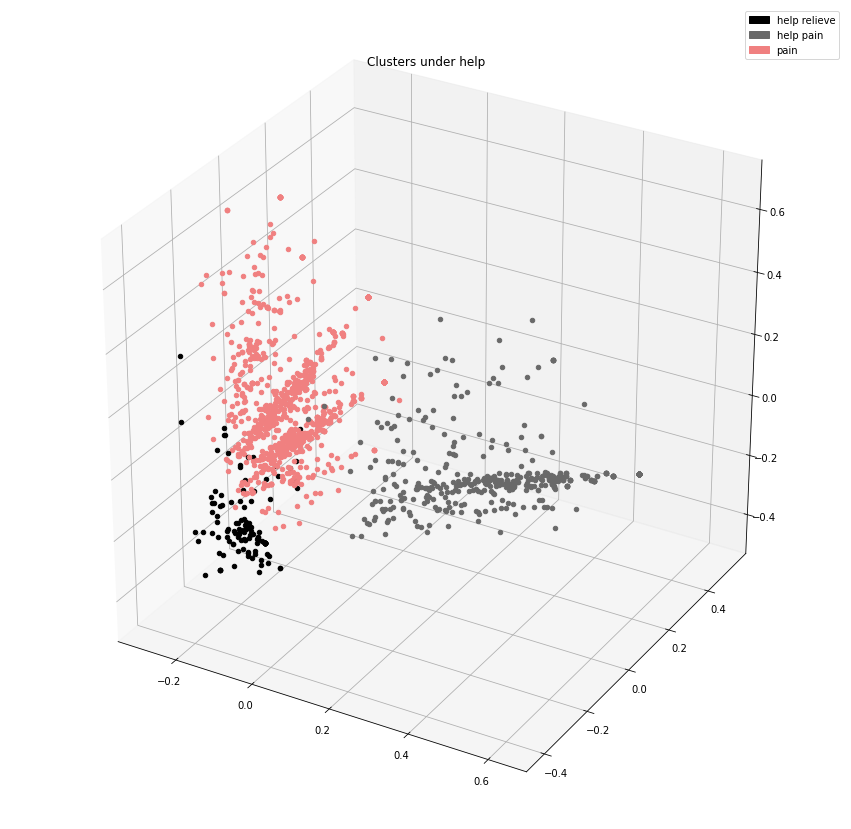

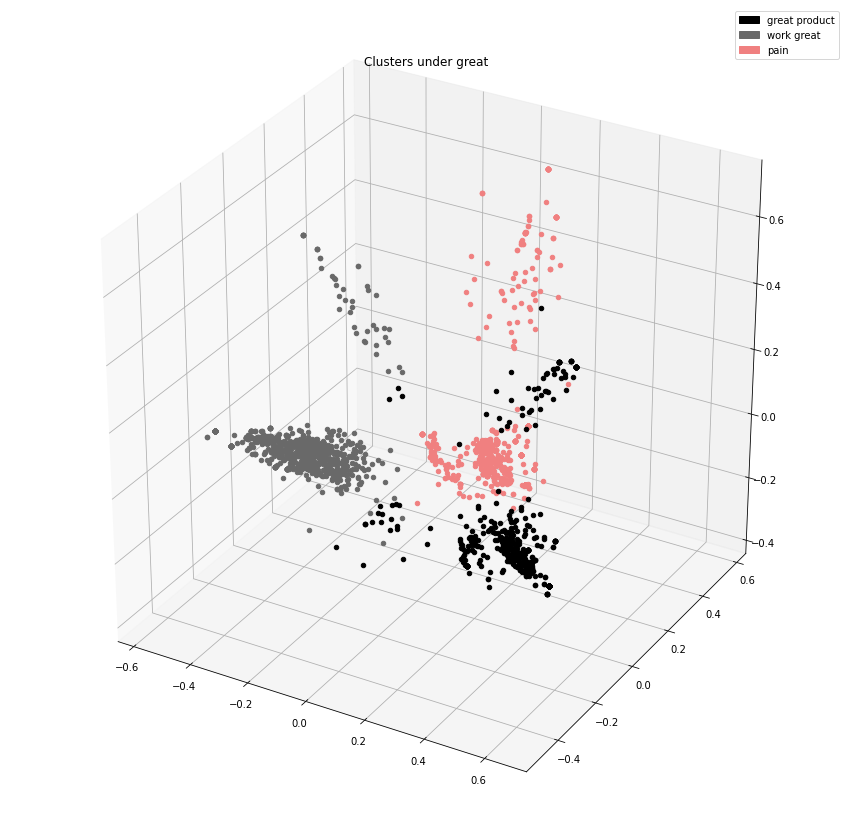

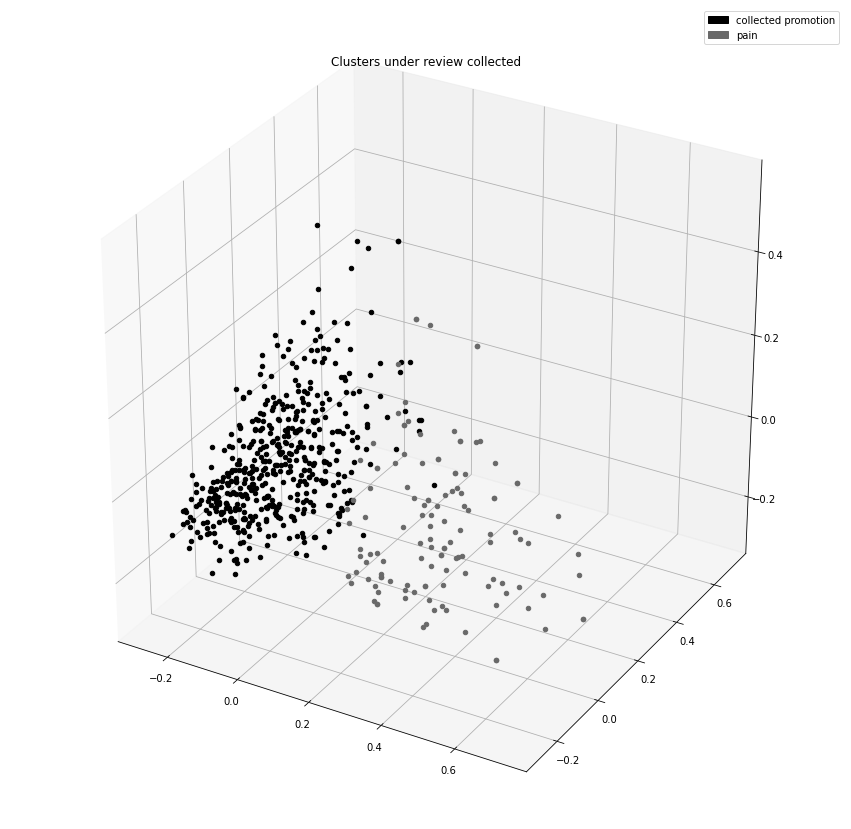

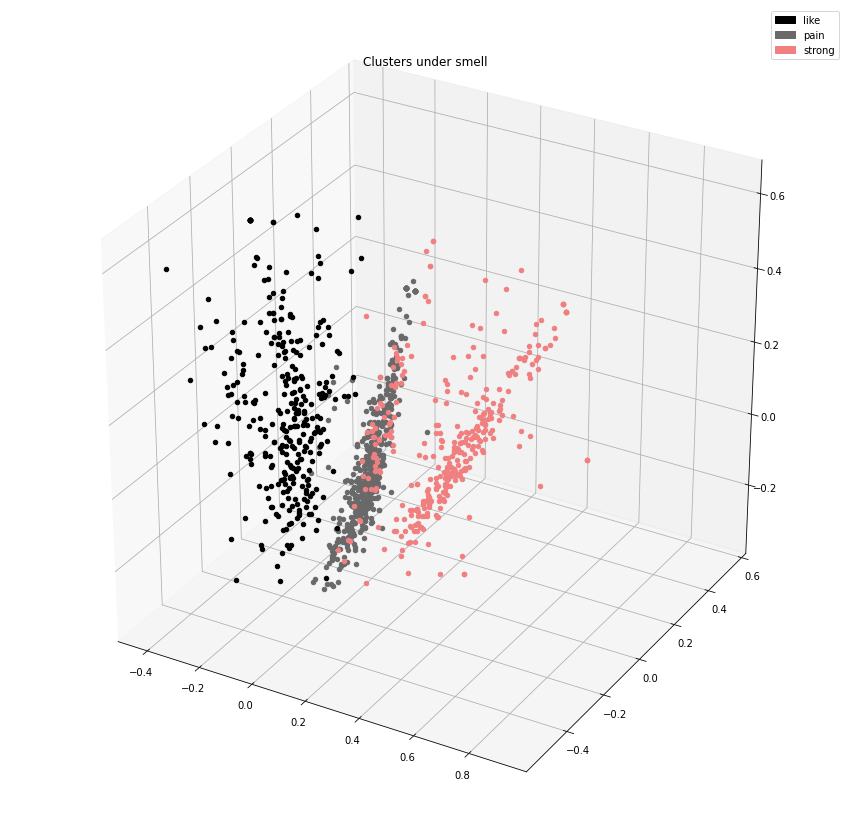

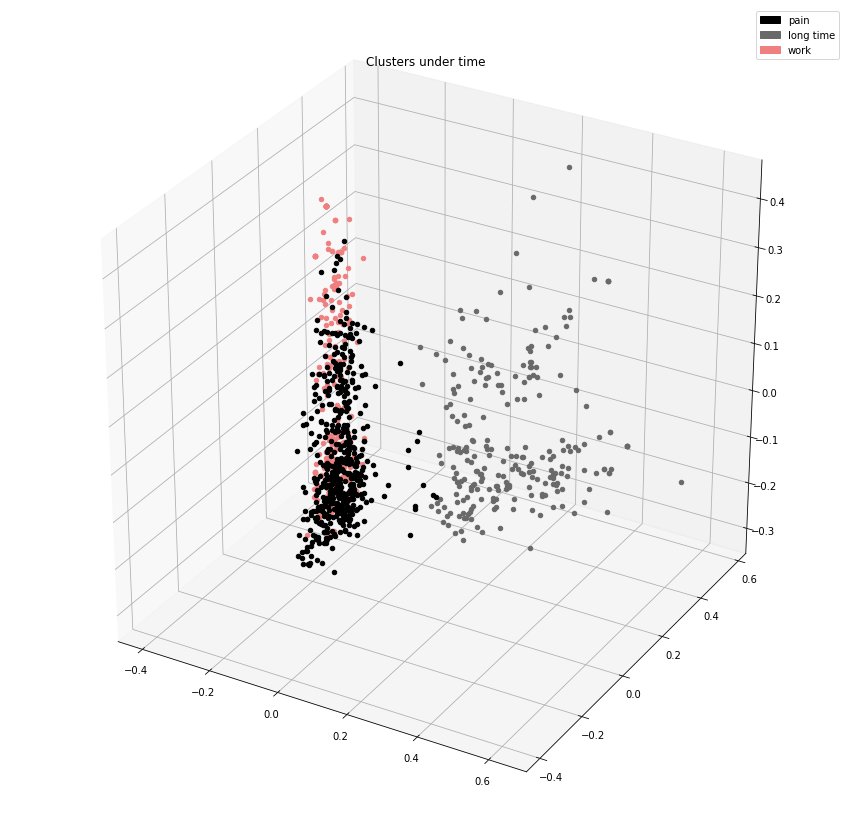

In [17]:
# Hyperparameter to be tuned
num_clusters_2 = 3

level_2_pred = []
level_2_names = []
level_2_scores = []

num_clusters = len(level_1_names)
for i in range(num_clusters):
  level_1_data = level_1_clusters[i]
  level_1_processed = level_1_text[i]

  pca = PCA(n_components=3)
  pca_data = pca.fit_transform(level_1_data)

  level_2_pred_, _, _, level_2_names_, level_2_scores_ = clustering_and_labelling(level_1_data, level_1_processed, num_clusters_2, level_1_names[i])
  level_2_pred.append(level_2_pred_)
  level_2_names.append(level_2_names_)
  level_2_scores.append(level_2_scores_)

  plot_scatter(pca_data, level_2_pred_, level_2_names_, ("Clusters under " + level_1_names[i]))

In [18]:
# Visualising the label tree
for i in range(len(level_1_names)):
  print (level_1_names[i], end="\n\t")
  for j in range(len(level_2_names[i])):
    print (level_2_names[i][j], end=", ")
  print ("\b\b\n\tSilhouette score = ", level_2_scores[i])

pain
	work, muscle, arthritis pain, 
	Silhouette score =  0.0455165659797301
work
	work better, fast, pain, 
	Silhouette score =  -0.034994421121334295
pain relief
	relief, 
	Silhouette score =  0.20739407255791856
product
	product work, pain, 
	Silhouette score =  0.35791984015370826
good
	pain, product, good price, 
	Silhouette score =  0.25557586891863615
cramp
	night, work, foot, 
	Silhouette score =  0.08598733573957791
patch
	pain, salonpas, 
	Silhouette score =  0.13676499099444328
help
	help relieve, help pain, pain, 
	Silhouette score =  0.12432810362373105
great
	great product, work great, pain, 
	Silhouette score =  0.32831686805031846
review collected
	collected promotion, pain, 
	Silhouette score =  0.12119940443423449
smell
	like, pain, strong, 
	Silhouette score =  0.11335482353513353
time
	pain, long time, work, 
	Silhouette score =  0.1472644333055259
